In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/skylab_instagram_datathon_dataset.csv", delimiter=";")

In [3]:
# Convert 'date' column to datetime format
df["period_end_date"] = pd.to_datetime(df['period_end_date'], format="%Y-%m-%d")

# Sort DataFrame by 'date' column in ascending order
df = df.sort_values(by='period_end_date', ascending=True)

In [4]:
df_renamed = df.rename(columns={"business_entity_doing_business_as_name": "brand", "legal_entity_name": "company", "ultimate_parent_legal_entity_name": "parent_company"})

In [78]:
all_brands = df_renamed[df_renamed["brand"] == "All Brands"]
brands = df_renamed[df_renamed["brand"] != "All Brands"]
len(brands)

676558

In [79]:
# Drop data with na for the last 6 years
year_lag = 4
na_brands = ['Simmons', 'LP Building Products', 'East Bay', 'Bottega Veneta',
       "Carter's", 'Sperry', 'Serta', 'Nature Valley', 'Nautica',
       'Bobbi Brown', 'Anta', "OshKosh B'gosh", 'Kanebo',
       'Michelob Ultra', 'Skip Hop', 'Runnerspoint', 'Fashion Nova',
       'Modelo', 'Yoplait', 'Invisalign', 'CertainTeed', 'CCC Shoes',
       'John Frieda', 'Whiskas', 'Vegetarian Butcher', 'Tempur',
       'Breville', 'Schweppes', 'Becca', 'Sizeer', 'iRobot',
       'Ninja Kitchen', 'About You', 'Sensai', 'Izod', 'Restylane',
       'Ecovacs', "Beck's", 'Shark Home', 'Garden Gourmet', 'Revanesse',
       'Sol', 'Elemis', 'Hoegaarden', 'Bulgari Beauty', 'Carla Amorim',
       'Royal Building Products', 'The Meatless Farm', 'Tineco',
       'Roborock', 'Superdown', 'ORCA', 'Burberry Beauty',
       'Pure Farmland', 'Spaten', 'Dysport', 'Sculptra', 'Temu',
       'Finding Unicorn', 'Pop Mart', 'Rolife', 'Wahoo Fitness',
       'Belotero', 'My Shoes', 'Tonica Antarctica', 'Value Village',
       'Pacifico', 'ShopGoodwill']
# Filter the DataFrame
brands = brands[~brands["brand"].isin(na_brands)]

# Print the filtered DataFrame
len(brands)

630721

In [80]:
# Drop unused years
max_date = brands["period_end_date"].max()
brands = brands[brands["period_end_date"] > max_date - pd.DateOffset(years=year_lag)]

In [83]:
def preprocess_data(data):

    data = data[[ "followers", "likes",  "videos", "pictures", "comments", "period_end_date", "brand"]].copy()
    data['content'] = data['videos'] + data['pictures']
    data['engagement'] = data['likes'] + data['comments']
    data['value'] = data['engagement'] / data['content']
    data = data.drop(["pictures", "followers", "content", "engagement", "videos", "likes", "comments"], axis=1)

    return data

brands = preprocess_data(brands)
#all_brands = preprocess_data(all_brands)

In [85]:
brands.head()

,period_end_date,brand,value
400848,2019-09-21,Build A Bear,4882.647059
276585,2019-09-21,Alexandre Birman,1734.718750
569777,2019-09-21,Under Armour,4016.847682
331996,2019-09-21,Gap,408.079727
2298,2019-09-21,Tim Horton's,4942.420000


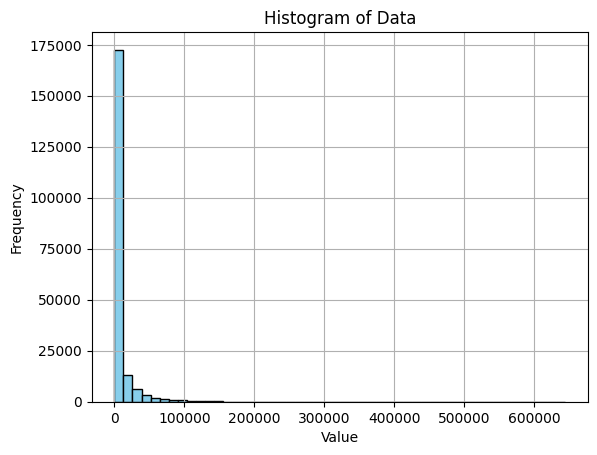

In [86]:
import matplotlib.pyplot as plt

# Plot the data and the regression line
plt.hist(brands["value"].values, bins=50, color='skyblue', edgecolor='black')  # Adjust bins for desired granularity
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(True)
plt.show()

## Model

In [87]:
# Splitting data
limit = brands['period_end_date'].max() - pd.DateOffset(months=3)
train_data = brands[brands['period_end_date'] < limit]
test_data = brands[brands['period_end_date'] >= limit]

In [88]:
train_data.head()

,period_end_date,brand,value
400848,2019-09-21,Build A Bear,4882.647059
276585,2019-09-21,Alexandre Birman,1734.718750
569777,2019-09-21,Under Armour,4016.847682
331996,2019-09-21,Gap,408.079727
2298,2019-09-21,Tim Horton's,4942.420000


In [90]:
from sklearn.preprocessing import LabelEncoder

labelers = []
to_label = ["brand"]

for l in to_label:
    labeler = LabelEncoder()
    train_data.loc[:, l] = labeler.fit_transform(train_data[l])
    labelers.append(labeler)

In [91]:
train_data.head()

,period_end_date,brand,value
400848,2019-09-21,50,4882.647059
276585,2019-09-21,10,1734.718750
569777,2019-09-21,385,4016.847682
331996,2019-09-21,140,408.079727
2298,2019-09-21,371,4942.420000


In [98]:
train_data = train_data.drop_duplicates()

In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Preprocess the data
# Assuming 'period_end_date' is not needed for modeling
features = ['brand']
target = 'value'

# Group the data by (brand, compset, compset_group)
grouped_data = train_data.groupby(features)

# Initialize lists to store sequences and targets
sequences = []
targets = []
seq_length = len(train_data["period_end_date"].unique())

# Iterate over each group
for group, group_df in grouped_data:
    # Sort by period_end_date if needed
    group_df = group_df.sort_values(by='period_end_date')
    
    # Extract features and target
    X_group = group_df[features]  # Exclude the 'value' column
    y_group = group_df[target]
    
    # Convert to numpy arrays
    X_group = X_group.values
    y_group = y_group.values
    
    sequences.append(X_group)
    targets.append(y_group)


In [112]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Convert lists to numpy arrays
sequences = np.array(sequences, dtype=np.float32)
targets = np.array(targets, dtype=np.float32)

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(sequences, targets, epochs=50, batch_size=32)

# Generate predictions
predictions = model.predict(sequences)

# Calculate MSE
mse = mean_squared_error(targets, predictions)
print("Mean Squared Error:", mse)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: nan
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: nan
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: nan
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: nan
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: nan
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: nan
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: nan
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: nan
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: nan
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: nan
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: nan
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: nan
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: nan
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: nan
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: nan
Epoch 16/50
14/14 ━━━━━━━━━━━━━━━━

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').